In [1]:
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import xskillscore as xs

from unseen import fileio
from unseen import spatial_selection
from unseen import general_utils
from unseen import time_utils

In [2]:
lat = 47.45
lon = 237.69

## Reanalysis data

In [3]:
obs_hgt_file = '/g/data/xv83/dbi599/seatac/data/h500_ERA5_hourly_2021-06-28.grib'

In [4]:
ds_hgt = xr.open_dataset(obs_hgt_file, engine='cfgrib')
da_h500 = ds_hgt['z'].mean('time')
da_h500 = da_h500 / 9.80665

In [5]:
def plot_obs(da, distance):
    """ """
    h500_levels = np.arange(5300, 6000, 50)
    
    fig = plt.figure(figsize=[12, 6])
    map_proj = ccrs.LambertConformal(
        central_longitude=lon,
        central_latitude=lat,
        standard_parallels=[lat, lat]
    )
    ax = fig.add_subplot(111, projection=map_proj)
    lines = da.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=h500_levels,
#        colors=['0.1']
    )
    #ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
    ax.coastlines()
    ax.plot(lon, lat, 'bo', transform=ccrs.PlateCarree())
    ax.set_extent([lon - distance, lon + distance, lat - distance, lat + distance])
    ax.gridlines(linestyle='--', draw_labels=True)
    ax.set_title('500 hPa geopotential height, 28 June 2021')
    plt.show()

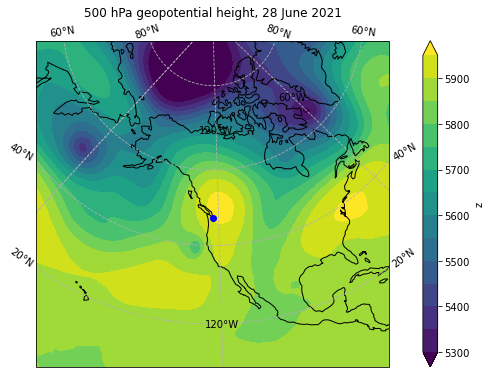

In [6]:
plot_obs(da_h500, 40)

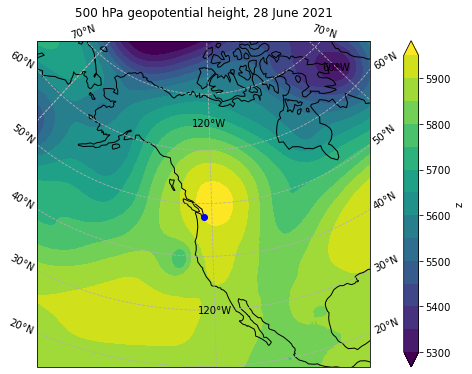

In [7]:
plot_obs(da_h500, 30)

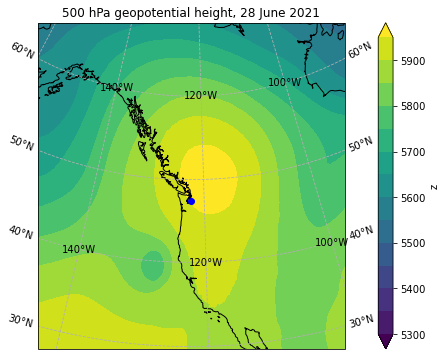

In [8]:
plot_obs(da_h500, 20)

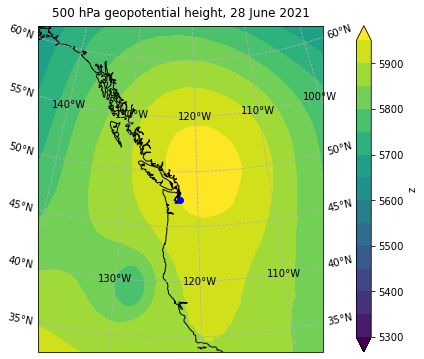

In [9]:
plot_obs(da_h500, 15)

## Model data

In [7]:
model_file = '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20000501/atmos_isobaric_daily.zarr.zip'

In [8]:
ds_model = fileio.open_dataset(
    model_file,
    variables=['h500', 'tasmax'],
    metadata_file='/home/599/dbi599/unseen/config/dataset_cafe_daily.yml',
)

In [9]:
da_model_tasmax = spatial_selection.select_point_region(ds_model['tasmax'], [lat, lon])

In [10]:
da_model_tasmax = general_utils.convert_units(da_model_tasmax, 'C')

## Remap reanalysis data

In [11]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], ds_model['lat'].values),
        "lon": (["lon"], ds_model['lon'].values),
    }
)

In [12]:
regridder = xe.Regridder(da_h500, ds_out, "bilinear")

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [13]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_721x1440_90x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (721, 1440) 
Output grid shape:          (90, 144) 
Periodic in longitude?      False

In [14]:
dr_h500 = regridder(da_h500)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


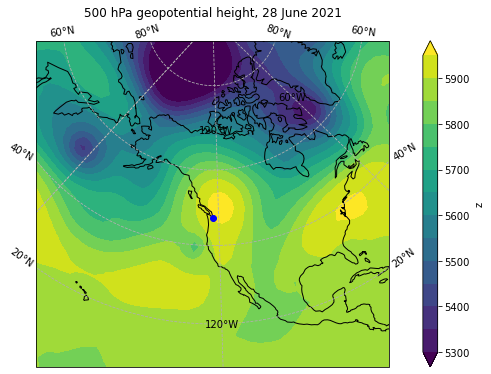

In [18]:
plot_obs(dr_h500, 40)

## RMSE

In [146]:
ds_model_tasmax = da_model_tasmax.to_dataset()

In [20]:
ds_txx = time_utils.temporal_aggregation(ds_model_tasmax, 'A-DEC', 'D', 'max', ['tasmax'])

In [22]:
ds_txx_idx = da_model_tasmax.resample(time='A-DEC').reduce(np.nanargmax, dim='time')

In [25]:
day_count = da_model_tasmax.resample(time='A-DEC').count(dim='time')

In [128]:
day_count.isel({'ensemble': 0}).values

array([245, 365, 365, 365, 366, 365, 365, 365, 366, 365, 120])

In [110]:
ds_txx = ds_txx.compute()

In [111]:
ds_txx_idx = ds_txx_idx.compute()

In [112]:
day_count = day_count.compute()

In [116]:
da_model_tasmax = da_model_tasmax.compute()

In [165]:
distance = 30
box = [lat - distance, lat + distance, lon - distance, lon + distance]
dr_h500_box = spatial_selection.select_box_region(dr_h500, box)
da_model_h500_box = spatial_selection.select_box_region(ds_model['h500'], box)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [166]:
#def is_jja(month):
#    return (month >= 6) & (month <= 8)
#da_model_tasmax = da_model_tasmax.sel(time=is_jja(ds_model['time.month']))
#da_model_h500 = ds_model['h500'].sel(time=is_jja(ds_model['time.month']))

In [167]:
dr_h500_box = dr_h500_box.compute()

In [168]:
da_model_h500_box = da_model_h500_box.compute()

In [169]:
def calc_rmse(ensemble_number):
    """Calculate the RMSE values for a given ensemble member"""

    day_offset = np.append(0, day_count.cumsum(dim='time').isel({'ensemble': ensemble_number}).values[0:-1])
    time_selection = ds_txx_idx.isel({'ensemble': ensemble_number}).values + day_offset

    rmse = xs.rmse(
        dr_h500_box,
        da_model_h500_box.isel({'time': time_selection, 'ensemble': ensemble_number}),
        dim=['lat', 'lon'],
        weights=None,
        skipna=False,
        keep_attrs=True
    )
    txx_vals = da_model_tasmax.isel({'time': time_selection, 'ensemble': ensemble_number}).values
    expected_txx_vals = ds_txx['tasmax'].isel({'ensemble': ensemble_number}).values
    np.testing.assert_array_equal(txx_vals, expected_txx_vals)
    
    return rmse.values, txx_vals

In [170]:
n_members = len(da_model_tasmax['ensemble'])
rmse_array = np.array([])
txx_array = np.array([])
for ensemble_number in range(n_members):
    print(f'ensemble member: {ensemble_number}')
    ensemble_rmse, ensemble_txx = calc_rmse(ensemble_number)
    rmse_array = np.append(rmse_array, ensemble_rmse[1: -1])
    txx_array = np.append(txx_array, ensemble_txx[1: -1])

ensemble member: 0
ensemble member: 1
ensemble member: 2
ensemble member: 3
ensemble member: 4
ensemble member: 5
ensemble member: 6
ensemble member: 7
ensemble member: 8
ensemble member: 9
ensemble member: 10
ensemble member: 11
ensemble member: 12
ensemble member: 13
ensemble member: 14
ensemble member: 15
ensemble member: 16
ensemble member: 17
ensemble member: 18
ensemble member: 19
ensemble member: 20
ensemble member: 21
ensemble member: 22
ensemble member: 23
ensemble member: 24
ensemble member: 25
ensemble member: 26
ensemble member: 27
ensemble member: 28
ensemble member: 29
ensemble member: 30
ensemble member: 31
ensemble member: 32
ensemble member: 33
ensemble member: 34
ensemble member: 35
ensemble member: 36
ensemble member: 37
ensemble member: 38
ensemble member: 39
ensemble member: 40
ensemble member: 41
ensemble member: 42
ensemble member: 43
ensemble member: 44
ensemble member: 45
ensemble member: 46
ensemble member: 47
ensemble member: 48
ensemble member: 49
ensemble m

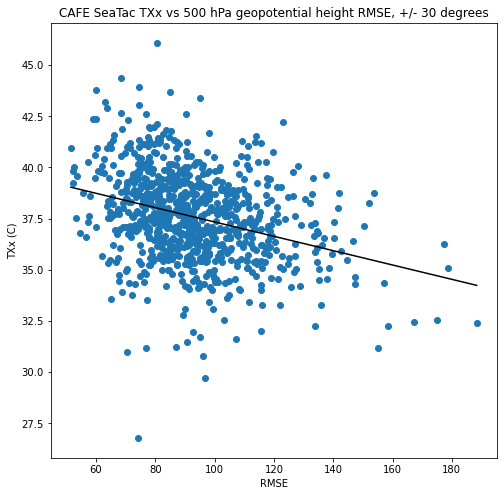

In [171]:
plt.figure(figsize=[8, 8])
plt.scatter(rmse_array, txx_array)
plt.plot(
    np.unique(rmse_array),
    np.poly1d(np.polyfit(rmse_array, txx_array, 1))(np.unique(rmse_array)),
    color='black',
)
plt.xlabel('RMSE')
plt.ylabel('TXx (C)')
plt.title(f'CAFE SeaTac TXx vs 500 hPa geopotential height RMSE, +/- {distance} degrees')
plt.show()

In [172]:
len(rmse_array)

864

In [173]:
9 * 96

864